In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def find_eig(laplacian):
    eigenvalues, eigenvectors = np.linalg.eig(laplacian)
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]
#     print(eigenvalues,'\n'*2 ,eigenvectors)
    return eigenvalues, eigenvectors

In [3]:
def find_eig_torch(laplacian: torch.Tensor):
    eigenvalues, eigenvectors = torch.linalg.eig(laplacian)
    eigenvalues = eigenvalues.to(float)
    eigenvectors = eigenvectors.to(float)
    sorted_indices = torch.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]
#     print(eigenvalues,'\n'*2 ,eigenvectors)
    return eigenvalues, eigenvectors

In [4]:
def print_eig(eigenvalues, eigenvectors, n_comp = 5):
    eigen_sum = eigenvalues.sum()
    eigenvalues = eigenvalues[:n_comp]
    figsize = (len(eigenvalues)*3, 14)
    
    fig, ax = plt.subplots(len(eigenvalues), 2, figsize=figsize, sharex=True)
    for n in range(len(eigenvalues)):
        ax[n, 0].plot(eigenvectors[:,n], '*')
        ax[n, 0].set_title(f'{n}. eigenvalue = {eigenvalues[n]}')
    
    ax[0, 1].plot(eigenvalues, '*')
    ax[0, 1].set_title('Eigenvalues')
    plt.suptitle(f'Dirichlet energy: {eigen_sum}')

In [5]:
def normalize_A_torch(a_m, d_m):
    return torch.sqrt(torch.linalg.inv(d_m))@a_m@torch.sqrt(torch.linalg.inv(d_m))

In [6]:
def normalize_A(a_m, d_m):
    return np.sqrt(np.linalg.inv(d_m))@a_m@np.sqrt(np.linalg.inv(d_m))

#1

0, 1, 2, 3, 4

0 -> 1 -> 2


1 -> 3

3 -> 4

# Grafo reale

In [7]:
## caso intermedio
# A = np.array([
#     [0, 1, 1, 0, 0], 
#     [1, 0, 1, 1, 0],
#     [1, 1, 0, 0, 0],
#     [0, 1, 0, 0, 1],
#     [0, 0, 0, 1, 0]
# ]).astype(float)

# caso con due grafi disconnessi
A = np.array([
    [0, 1, 1, 0, 0], 
    [1, 0, 1, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0]
]).astype(float)

# tutto connesso
# A = np.array([
#     [0, 1, 1, 1, 1], 
#     [1, 0, 1, 1, 1],
#     [1, 1, 0, 1, 1],
#     [1, 1, 1, 0, 1],
#     [1, 1, 1, 1, 0]
# ]).astype(float)

# # tutto sconnesso
# A = np.ones((100, 32))

# A += np.eye(A.shape[0])

In [8]:
D = np.diag(A.sum(1))
L_norm = np.eye(A.shape[0])-normalize_A(A, D)
L = D-A

In [9]:
L_norm = np.eye(A.shape[0])-normalize_A(A, D)

In [10]:
L = D-A
L

array([[ 2., -1., -1.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [-1., -1.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0., -1.,  1.]])

In [11]:
L_norm

array([[ 1. , -0.5, -0.5,  0. ,  0. ],
       [-0.5,  1. , -0.5,  0. ,  0. ],
       [-0.5, -0.5,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. , -1. ],
       [ 0. ,  0. ,  0. , -1. ,  1. ]])

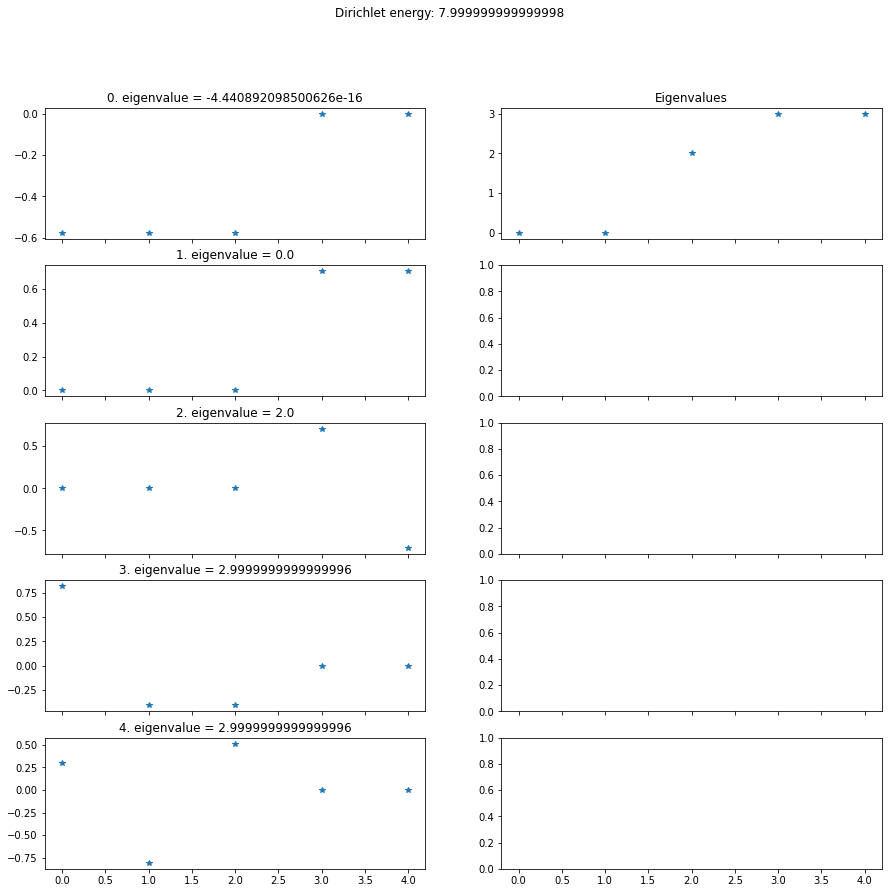

In [12]:
# eigenvalues, eigenvectors = find_eig(L)

# print_eig(eigenvalues, eigenvectors)
eigenvalues, eigenvectors = find_eig(L)

print_eig(eigenvalues, eigenvectors)


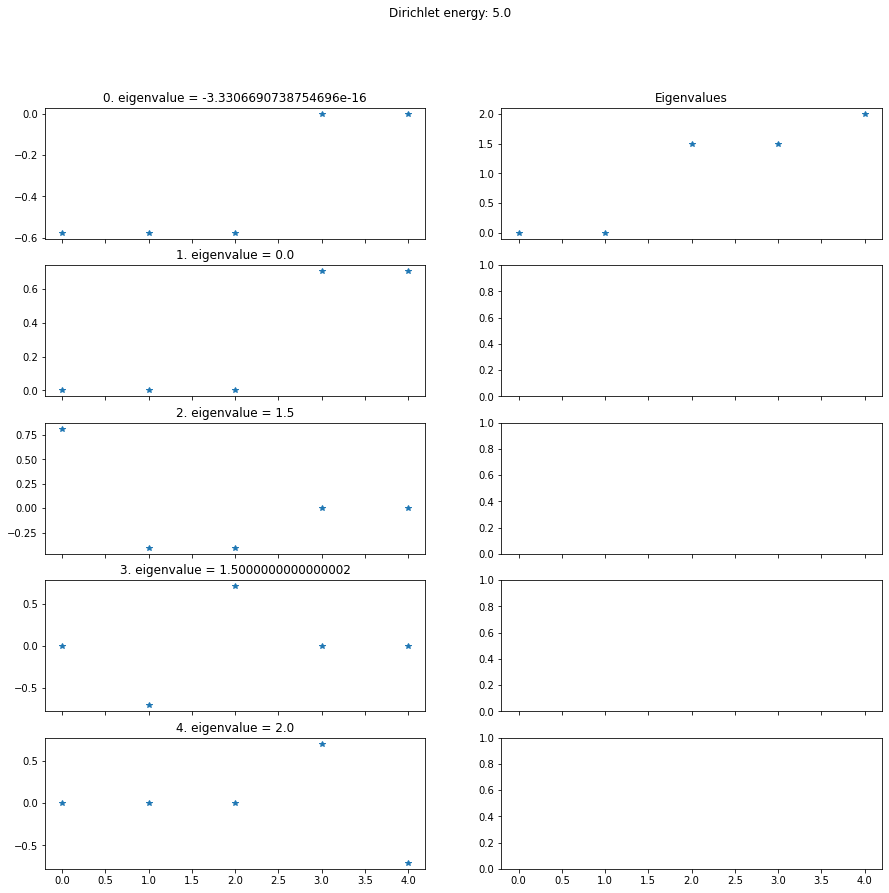

In [13]:
print_eig(*find_eig(L_norm))

L'energia di dirichlet si azzera quando tutti i punti sono disconnessi tra loro

# Grafo da dati

In [14]:
torch.cuda.empty_cache()

In [23]:
# temperature
sigma=1.

data = torch.Tensor([
    [1, 2, 1, 2],
    [1, 1, 1, 2],
    [3, 3, 3, 2],
    [18, 4, 4, 15],
    [19, 10, 10, 14],
]).to('cuda')

data = torch.Tensor([
    [1, 2, 1, 2],
    [1, 1, 1, 2],
    [1, 1, 1, 1],
    [2, 1.2, 1, 2],
    [1, 1.2, 2, 1.2],
]).to('cuda')

# data = torch.Tensor([
#     [5, 5, 5, 5],
#     [10, 10, 10, 10],
#     [1, 1, 1, 1],
#     [40, 40, 40, 40],
#     [500, 500, 500, 500],
# ]).to('cuda')
# data = np.random.rand(3000,32)
# data = torch.rand((4000, 32)).to('cuda')

In [24]:
def calc_D_L_torch(data: torch.Tensor):
    dist_matrix = ((data[None, ...] - data.unsqueeze(1)) ** 2).sum(-1)
    # compute affinity matrix
    A = torch.exp(-dist_matrix / (sigma ** 2))

    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

In [25]:
def calc_D_L_torch_knn(data: torch.Tensor):
    dist_matrix = ((data[None, ...] - data.unsqueeze(1)) ** 2).sum(-1)
    # compute affinity matrix
    A = torch.exp(-dist_matrix / (sigma ** 2))

    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

In [26]:
dist_matrix = ((data[None, ...] - data.unsqueeze(1)) ** 2).sum(-1)
# compute affinity matrix
A = torch.exp(-dist_matrix / (sigma ** 2))

- prendo A
- ogni iesima riga di A mi dice la distanza di quell'iesimo punto da tutti i punti
- per ogni i scelgo gli n più vicini
- inserisco un 1 in quelli, 0 negli altri
- inserisco 0 sulla diagonale

from sklearn.neighbors import kneighbors_graph
matrix = kneighbors_graph(data.cpu(), 2, mode='connectivity')

In [27]:
dist_matrix

tensor([[0.0000, 1.0000, 2.0000, 1.6400, 2.2800],
        [1.0000, 0.0000, 1.0000, 1.0400, 1.6800],
        [2.0000, 1.0000, 0.0000, 2.0400, 1.0800],
        [1.6400, 1.0400, 2.0400, 0.0000, 2.6400],
        [2.2800, 1.6800, 1.0800, 2.6400, 0.0000]], device='cuda:0')

In [28]:
A

tensor([[1.0000, 0.3679, 0.1353, 0.1940, 0.1023],
        [0.3679, 1.0000, 0.3679, 0.3535, 0.1864],
        [0.1353, 0.3679, 1.0000, 0.1300, 0.3396],
        [0.1940, 0.3535, 0.1300, 1.0000, 0.0714],
        [0.1023, 0.1864, 0.3396, 0.0714, 1.0000]], device='cuda:0')

In [33]:
((A + A.T) > 0).float()

tensor([[0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1.],
        [0., 1., 0., 0., 1.],
        [1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.]], device='cuda:0')

In [43]:
def calc_A_knn(matrix: torch.Tensor, k: int, distance: bool, symmetric: bool = False):
    new_A = torch.clone(matrix)
    mask = torch.diag(torch.ones(new_A.shape[0]))
    if distance:
        new_A[mask==1] = +torch.inf
    else:
        new_A[mask==1] = -torch.inf
    final_A = torch.zeros_like(new_A)

    idxes = new_A.topk(k, largest=False if distance else True)[1]
    for i in range(idxes.shape[0]):
        final_A[i, idxes[i,:]] = 1
    if symmetric:
        final_A = ((final_A + final_A.T) > 0).float()
        # final_A = 0.5*(final_A + final_A.T)
    return final_A

In [44]:
distance = True
A = calc_A_knn(dist_matrix, distance=True, k=2, symmetric=True)
# A = 0.5 * (A + A.T)

In [45]:
A

tensor([[0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 1.0000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 0.0000, 0.0000]], device='cuda:0')

In [46]:
# A, D, L = calc_D_L_torch(data)
D = torch.diag(A.sum(1))
# compute laplacian
L = D - A
L_norm = torch.eye(A.shape[0]).to('cuda')-normalize_A_torch(A, D)

eigenvalues, eigenvectors = find_eig_torch(L)

In [47]:
L.sum(1), L_norm.sum(1)

(tensor([0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([ 0.0144, -0.2879,  0.0144,  0.1869,  0.1869], device='cuda:0'))

In [48]:
L_norm

tensor([[ 1.0000, -0.4082,  0.0000, -0.5774,  0.0000],
        [-0.4082,  1.0000, -0.4082, -0.2357, -0.2357],
        [ 0.0000, -0.4082,  1.0000,  0.0000, -0.5774],
        [-0.5774, -0.2357,  0.0000,  1.0000,  0.0000],
        [ 0.0000, -0.2357, -0.5774,  0.0000,  1.0000]], device='cuda:0')

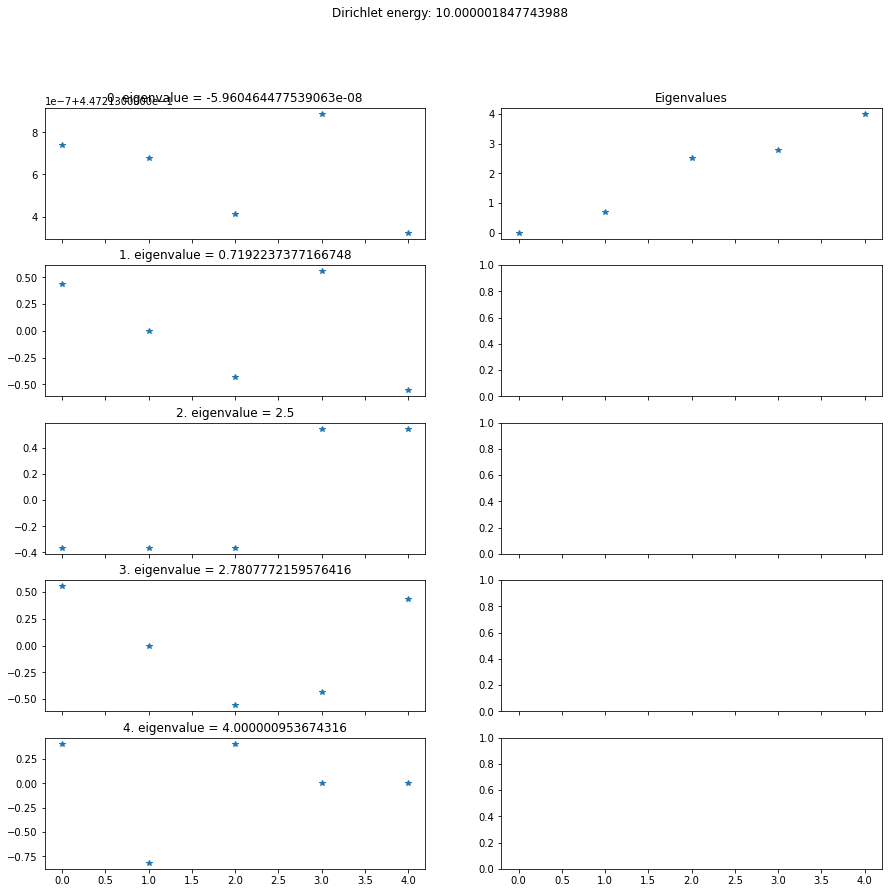

In [49]:
print_eig(eigenvalues.cpu().numpy(), eigenvectors.cpu().numpy())

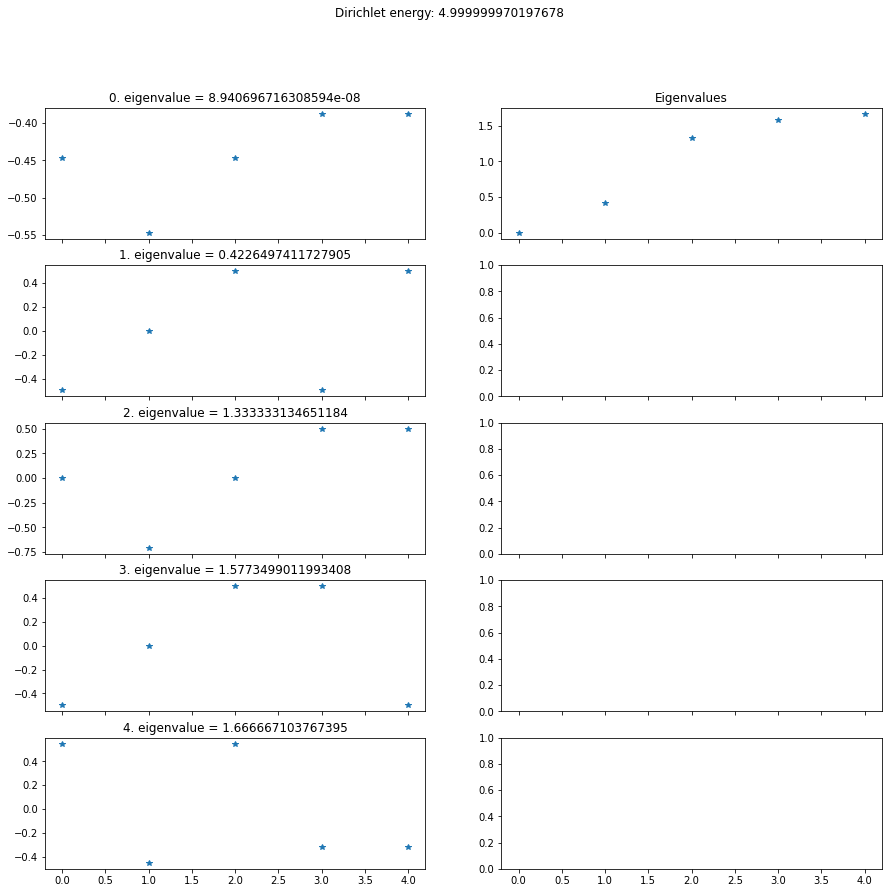

In [50]:
print_eig(*[x.cpu().numpy() for x in find_eig_torch(L_norm)])

In [186]:
A, D, L = calc_D_L_torch(data)
L_norm = torch.eye(A.shape[0]).to('cuda')-normalize_A_torch(A, D)

eigenvalues, eigenvectors = find_eig_torch(L)

In [187]:
L.sum(),L_norm.sum()

(tensor(-2.9802e-08, device='cuda:0'), tensor(0.0100, device='cuda:0'))

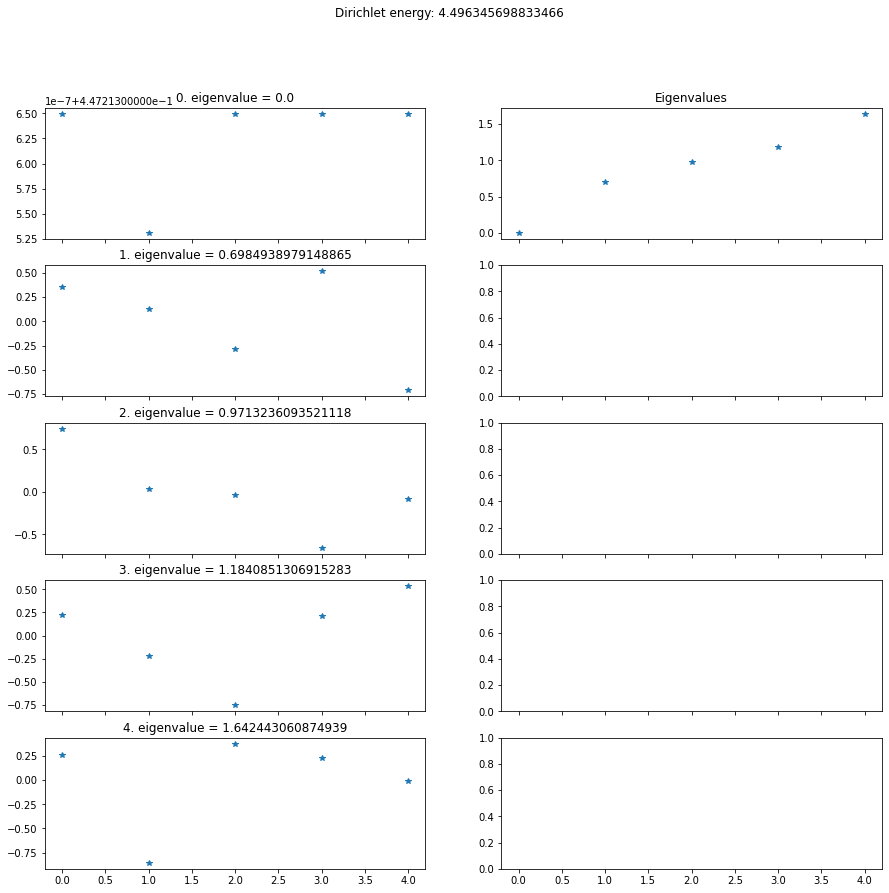

In [176]:
print_eig(eigenvalues.cpu().numpy(), eigenvectors.cpu().numpy())

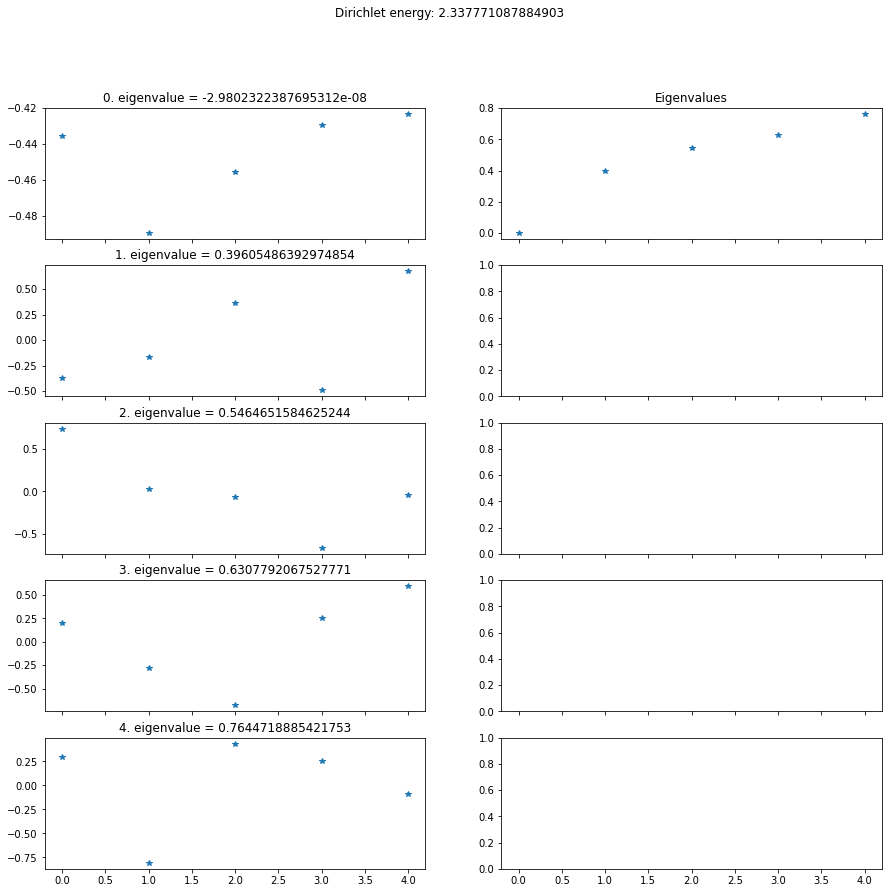

In [177]:
print_eig(*[x.cpu().numpy() for x in find_eig_torch(L_norm)])

- energia del laplaciano normalizzato va da 0 al numero di sample utilizzati per la costruzione del grafo - 1
- energia del laplaciano va da 0 a n_sample*(n_sample-1)

In [33]:
deltas = []
for k in range(1, eigenvalues.shape[0]):
    deltas.append(eigenvalues[k] - eigenvalues[k-1])
number_of_clusters = torch.Tensor(deltas).argmax().item()+1